# TODO: Create Accuracy score class
# TODO: Investigate dimensionality reduction using PCA
# TODO: Investigate training on images


In [23]:
# All required imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys

from constants import *

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.experimental import enable_iterative_imputer # This is required for IterativeImputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

sys.path.append(os.getcwd()) 
from constants import *



In [24]:
# Loading data
unclean_data = pd.read_csv('./data_set/combined.csv')
unclean_data.head()
# unclean_data.info()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class,pelvic_slope,direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Hernia,NaN,NaN,NaN,NaN,NaN,NaN
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Hernia,NaN,NaN,NaN,NaN,NaN,NaN
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Hernia,NaN,NaN,NaN,NaN,NaN,NaN
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Hernia,NaN,NaN,NaN,NaN,NaN,NaN
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Hernia,NaN,NaN,NaN,NaN,NaN,NaN


This data has 6 columns with approximately half having accurate float information and the remaining half is recorded as NaN. There are several options we can explore. 

1. We can use the data while removing the last 6 columns leaving 3000 rows of data and 7 columns. For a preliminary analysis we can drop the features initially. 

2. We can keep only complete records of data which will leave 1500 rows of data with 13 columns. Although this improves reliability, it is at the cost of reducing the sample size.

3. Lastly we can impute the missing information. In spinal biomechanics, there are mathematical interrelated. Pelvic Incidence, Sacral Slope and Pelvic Tilt are particularly useful because it can be demonstrated that PI is the arithmetic sum of the sacral slope (SS) pelvic tilt (PT), the two position-dependent variables that determine pelvic orientation in the sagittal plane (Labelle et al., 2005). Normalization will also be applied to mitigate issues with feature scaling. (Jolliffe, 2011)"

<h1>Missing Value Imputation</h1>
We will implement several imputation methods and evaluate their effects on the dataset. 

<strong>Mean Imputation:</strong> Missing values can be replaced with the mean of the feature. this is simple but can be influenced by outliers, potentially skewing the distribution. It can reduce variance since all missing entries are filled with an average value (C. Hounmenou, 2024)

<strong>Median Imputation:</strong> Replace missing values with the median of the feature. Median tends to be more robust to outliers then the mean, so this method preserves the central tenancy without being dragged by extrem values. In practice, mean and median can often yield similar results for symmetric distributions, but median imputation can better maintain the distribution shape when the data is skewed or contains outliers (M. Badiaa, 2024).

<strong>K-Nearest Neighbours Imputation (KNN):</strong> Using KNN estimates missing values using the mean, or median, of the <i>k</i> closest records, the feature space, that have values for that feature. This method leverages relationships between features, under the assumption that similar samples have similar feature values. By considering the distance in all dimensions, KNN imputation can preserve the multivariate structure of the data, often leading to more plausible imputed values (T. Kaur, 2025). 

<strong>Regression-based Imputation (Iterative/MICE):</strong> Uses regression models in an iterative fashion to predict missing values. Methods like MICE, Multiple Imputation by Chained Equations, or MissForest, treat each feature with missing data as a target and learn a regression, or decision tree, model from other features to predict the missing value (Y. Sun et al, 2023). This approach takes into account dependencies between variables and often yields higher quality imputations than mean/ median filling. It learns the likely value of a feature based on rathers, rather than inserting a constant value (T. Lekhansh, 2024). 

<h1>Comparison of Imputation Techniques</h1> 
After imputing missing values using each method, we will examine how they affect the data distribution and model performance. 

<strong>Distribution Effects:</strong> We will visualise and summarise the distribution of key features before and after imputation. For example, histograms and density plots will be compared to see if the mean or median imputation significantly shifts the distribution or compresses variability. 

Mean imputation may underestimate variance, since many values become the mean, whereas KNN or regression imputation may preserve the natural variance by inferring different values for different samples. We'll also check if any imputation methods might preserve relationships between feature, whereas mean/ median could break those correlations. 

<strong>Model Performance:</strong> We will train a baseline machine learning model, such as a logistic regression and compare their accuracy before and after imputation. The intuition is that a better imputation method provides data closer to the truth, potentially improving model accuracy. For example, median imputation might improve robustness on datasets with outliers, and more sophisticated approaches like KNN or MICE often yield higher predictive performance (lower error) since they utilize additional information from other features (S. Alam, 2023). By evaluating the model’s accuracy after each imputation, we can quantify the impact of each cleaning method. Any improvement in accuracy or reduction in error when using KNN/MICE over simple mean imputation would indicate that preserving multivariate structure is beneficial for this dataset.

Throughout this process, careful cross-validation will be used to ensure that the comparisons are fair, so differences in performance are due to imputation rather than random train test splits or variance in random state. 

Having ensured the data is clean and complete, the next step is to reduce its dimensionality to simplify the feature space.

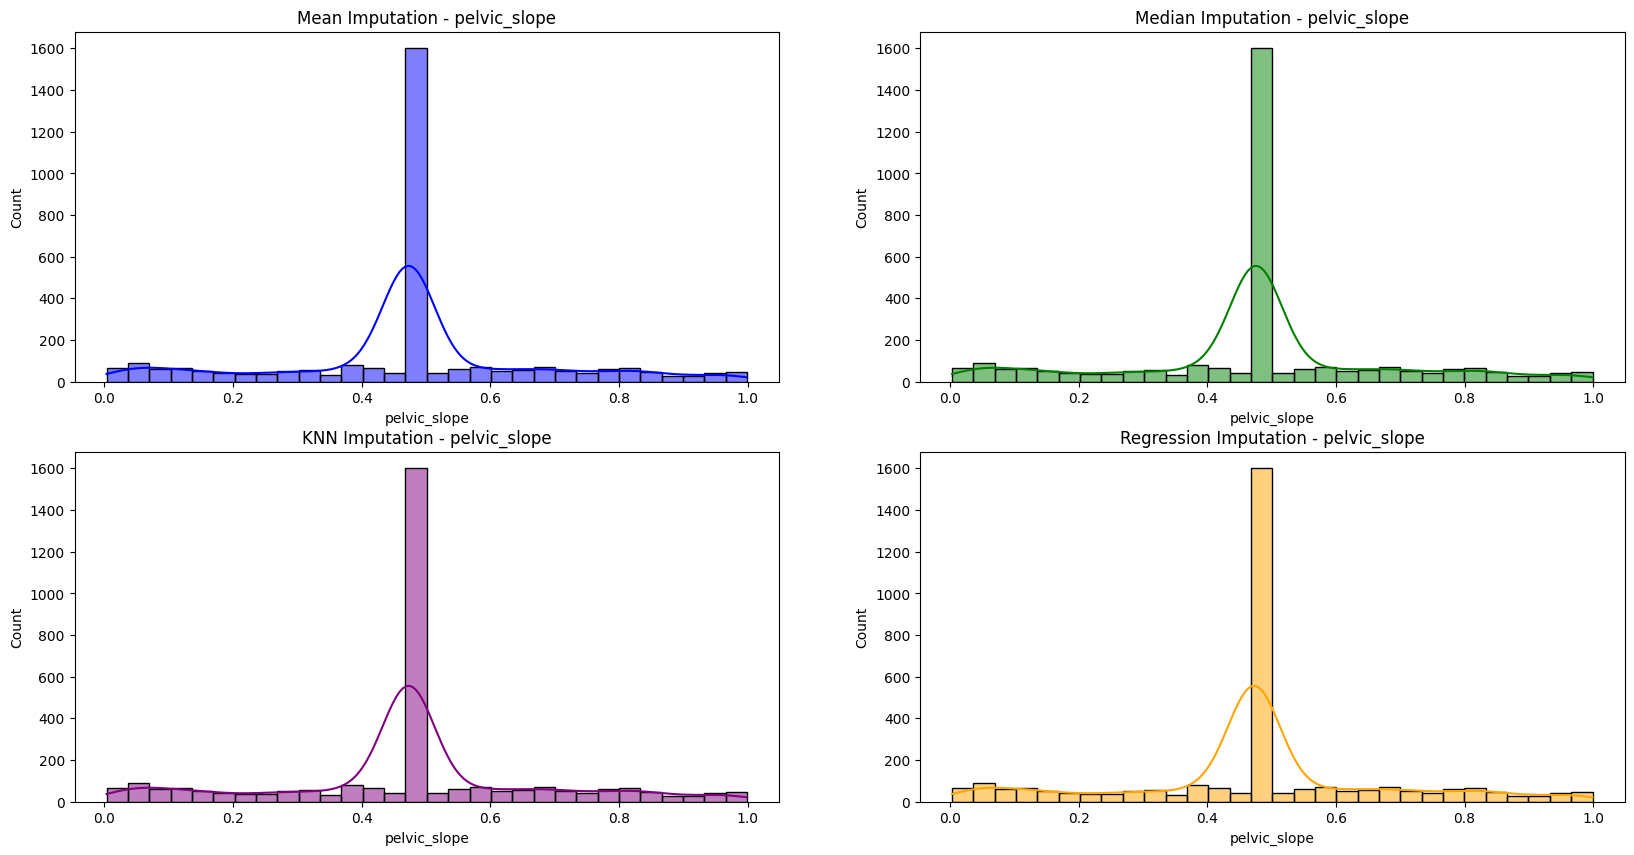

In [31]:
# TODO: Look at MSE before and after too 

columns_to_impute = [
    'pelvic_slope', 'direct_tilt', 'thoracic_slope', 
    'cervical_tilt', 'sacrum_angle', 'scoliosis_slope'
]

data_to_impute = unclean_data[columns_to_impute]

# Create imputers
mean_imputer = SimpleImputer(strategy='mean')
median_imputer = SimpleImputer(strategy='median')
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
regression_imputer = IterativeImputer(max_iter=10, random_state=FORTY_TWO)

# Fit and transform the data
mean_imputed_data = mean_imputer.fit_transform(data_to_impute)
median_imputed_data = median_imputer.fit_transform(data_to_impute)
knn_imputed_data = knn_imputer.fit_transform(data_to_impute)
regression_imputed_data = regression_imputer.fit_transform(data_to_impute)

# Convert the imputed data to a DataFrame
mean_df = pd.DataFrame(mean_imputed_data, columns=columns_to_impute)
median_df = pd.DataFrame(median_imputed_data, columns=columns_to_impute)
knn_df = pd.DataFrame(knn_imputed_data, columns=columns_to_impute)
regression_df = pd.DataFrame(regression_imputed_data, columns=columns_to_impute)

# Plotting the distribution for comparison
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()

sns.histplot(mean_df['pelvic_slope'], kde=True, bins=30, ax=axes[0], color='blue')
axes[0].set_title('Mean Imputation - pelvic_slope')

sns.histplot(median_df['pelvic_slope'], kde=True, bins=30, ax=axes[1], color='green')
axes[1].set_title('Median Imputation - pelvic_slope')

sns.histplot(knn_df['pelvic_slope'], kde=True, bins=30, ax=axes[2], color='purple')
axes[2].set_title('KNN Imputation - pelvic_slope')

sns.histplot(regression_df['pelvic_slope'], kde=True, bins=30, ax=axes[3], color='orange')
axes[3].set_title('Regression Imputation - pelvic_slope')

plt.tight_layout
plt.show()


<h1>2. Dimensionality Reduction</h1>
We will explore 3 dimensionality reduction techqniques Linear Discriminant Analysis (LDA), t-distributed Stochastic Neighbour Embedding (t-SNE), and Principal Component Analysis (PCA), to reduce feature dimensions and visualise the data structure. 

<h1>Ensemble Learning</h1> 

Ensemble learning is a technique that combines multiple models to produce a single, more robust prediction (Murel & Kavlakoglu, 2024). Rather than relying on a single model, ensemble methods aggregate the outputs of each model. Each model may capture different aspects or patterns in the data, this approach can have several advantages: 

<strong>Reduced variance:</strong> By averaging across models, ensemble methods can reduce the variance associated with indiviudal preductions, which oftens leads to imrpoved generalisation on unseen data.

<strong>Improved accuracy:</strong> Models like like Bagging, Boosting or Voting classifiers often outperform single models because they compensate for the weaknesses of one algorithm with the stregths of another (GeeksForGeeks, 2024).

<strong>Robustness:</strong> Ensembles are less sensitive to the noise associated with training data since outliers are diminished when combining multiple models (A. Jain, 2024)



<h1>Chosen Models</h1>

In Comparison of machine learning algorithms to identify and prevent low back injury by C. Paulino & J. Correa they analyse 6 algorithm types and have the most success with Support Vector Machine (SVM) and K-Nearest Neighbour (KNN). Their data set had under 200 rows of data and received accuracy scores over 90. 

For this research, we will be using Logistic Regression, Decision Tree Classifier, Random Forest Regressor, XGBoost, LightGBM as well as SWM and KNN. 

<h2>Option 1</h1>

In this option we will clean the data by removing the following headings 'pelvic_slope, direct_tilt, thoracic_slope, cervical_tilt, sacrum_angle, scoliosis_slope'

<h1>Parameter Tuning and Its Impact</h1>
Parameter tuning (or hyperparameter optimisation) is a crucial step in machine learning that can directly impact the model and its performance. Hyperparameters, such as the number of trees (n_estimators), maximum depth (max_depth), and minimum samples required for a split (min_samples_split) in a Random Forest, determine the model's complexity and learning capacity. The following are key several points regarding parameter tuning:

<strong>Model complexity:</strong> For instance, setting max_depth too low might result in a model that underfits (i.e. too simple to capture the underlying structure), while setting it too high may lead to overfitting (i.e. the model learns noise in the training data) (Amazon, 2024)

<strong>Bias-variance tradeoff:</strong>
Parameters such as n_estimators in ensemble models help manage the bias-variance tradeoff. A higher number of trees generally reduces variance but can increase computational cost (S. Prajapati, 2024).

<strong>Search techniques:</strong> Techniques like Grid Search and Randomised Search systematically explore combinations of hyperparameters. When paird with cross-validation, these techniques provide a robust estimate of how different parameter configurations perform on unseen data (A. Gupta, 2025). 

<strong>Performance comparison:</strong> By printing out the results from the hyperparameter grid, we can compare different configurations and indentify the best performing combination. This transparency is essential for reproducibility and for providing insights into why certain parameters work better. 

In [26]:
columns_to_keep = [
    PELVIC_INCIDENCE, PELVIC_TILT, LUMBAR_LORDOSIS_ANGLE, SACRAL_SLOPE, PELVIC_RADIUS, DEGREE_SPONDYLOLISTHESIS, PELVIC_SLOPE, DIRECT_TILT, THORACIC_SLOPE, CERVICAL_TILT, SACRUM_ANGLE, SCOLIOSIS_SLOPE
]

cleaned_data = unclean_data[columns_to_keep].copy()
X_cleaned = cleaned_data.drop(columns=[PELVIC_SLOPE, DIRECT_TILT,THORACIC_SLOPE, CERVICAL_TILT, SACRUM_ANGLE, SCOLIOSIS_SLOPE])
y_cleaned = cleaned_data[DEGREE_SPONDYLOLISTHESIS]

X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=FORTY_TWO)
X_train.shape, X_test.shape

forest_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 6, 10, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
}

rf = RandomForestRegressor(max_features='sqrt', min_samples_split=2, n_estimators=100, random_state=FORTY_TWO)


grid_search = GridSearchCV(rf, forest_params, cv=5)
grid_search.fit(X_train, y_train)
grid_search

print(grid_search.best_params_)


{'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}


<h1>Things to include</h1>
Include shap explanation as well as coefficient 
Check the available shap plots, maybe better than coefficient

use a param grid where applicable to ensure we have the best params

<H1>References</H1>

(Labelle et al., 2005) - Labelle, H., Roussouly, P., Berthonnaud, É., Dimnet, J. and O’Brien, M. (2005) ‘The importance of spino-pelvic balance in L5–S1: Developmental spondylolisthesis – A review of pertinent radiologic measurements’, Spine, 30(S6), pp. S27–S34.

Hounmenou, C. (2024) ‘Difference between outlier & skewness and how to control them in a model’, LinkedIn, Available at: https://www.linkedin.com/pulse/difference-between-outlier-skewness-how-control-them-model-hounmenou-mksre/ (Accessed: 19 March 2025).

Badiaa, M. (2024) ‘Discussion on handling missing data in machine learning’, Kaggle, Available at: https://www.kaggle.com/discussions/questions-and-answers/477356 (Accessed: 19 March 2025).

Kaur, T. (2025) ‘KNN imputation: The complete guide’, Medium, Available at: https://medium.com/@tarangds/knn-imputation-the-complete-guide-146f932870a7 (Accessed: 19 March 2025).

Sun, Y., Li, J., Xu, Y., Zhang, T. and Wang, X. (2023) ‘Deep learning versus conventional methods for missing data imputation: A review and comparative study’, Expert Systems with Applications, Available at: https://www.sciencedirect.com/science/article/pii/S0957417423007030 (Accessed: 19 March 2025).

Lekhansh, T. (2024) ‘Handling missing values in machine learning: Strategies for imputation and model robustness’, Medium, Available at: https://medium.com/@tyagi.lekhansh/handling-missing-values-in-machine-learning-strategies-for-imputation-and-model-robustness-4ba6287f1094 (Accessed: 19 March 2025).

Alam, S. (2023) ‘Missing value imputation in machine learning: A comparative study’, ScienceDirect, Available at: https://www.sciencedirect.com/science/article/pii/S2772662223001819 (Accessed: 19 March 2025).



In [27]:
import os
print(os.listdir())

['.git', '.gitignore', '2019AlaAlKafriPhD.pdf', 'constants.py', 'data_set', 'end-to-end-Ml project', 'ICA-Specification-Machine-Learning.pdf', 'images', 'main.ipynb', 'models', 'persistence', 'project.ipynb', 'scraper.py', 'text_processing', '__pycache__']
